In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Adds Gaussian Noise

In [5]:
noise_factor = 0.5
x_train_noisy = np.clip(x_train + noise_factor * np.random.normal(size=x_train.shape), 0., 1.)
x_test_noisy = np.clip(x_test + noise_factor * np.random.normal(size=x_test.shape), 0., 1.)

Autoencoder Architecture

In [6]:
input_img = tf.keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same', name='bottleneck')(x)

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [7]:
encoder = tf.keras.Model(input_img, encoded)

In [8]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [9]:
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=[early_stop]
)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.3977 - val_loss: 0.3150
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.3109 - val_loss: 0.3098
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3072 - val_loss: 0.3067
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.3042 - val_loss: 0.3048
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.3023 - val_loss: 0.3036
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3007 - val_loss: 0.3019
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2995 - val_loss: 0.3010
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2976 - val_loss: 0.3003
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2987 - val_loss: 0.2997
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2975 - val_loss: 0.2994
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2976 - val_loss: 0.2988
Epoch 12/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/st

Reconstruct and Encode Test Images

In [10]:
decoded_imgs = autoencoder.predict(x_test_noisy)
encoded_imgs = encoder.predict(x_test_noisy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


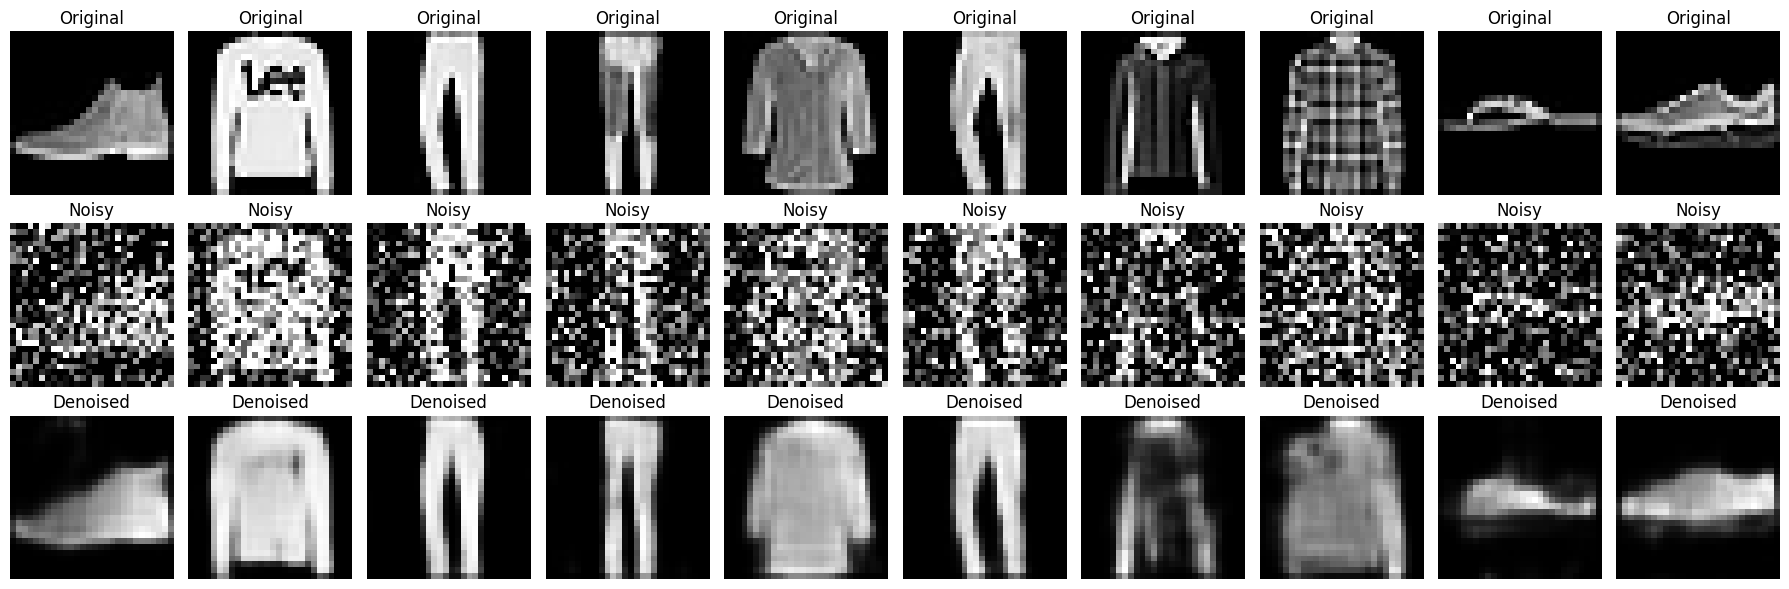

In [11]:
n = 10
plt.figure(figsize=(18, 6))
for i in range(n):
    # Original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Noisy input
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap="gray")
    plt.title("Noisy")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap="gray")
    plt.title("Denoised")
    plt.axis("off")
plt.tight_layout()
plt.show()

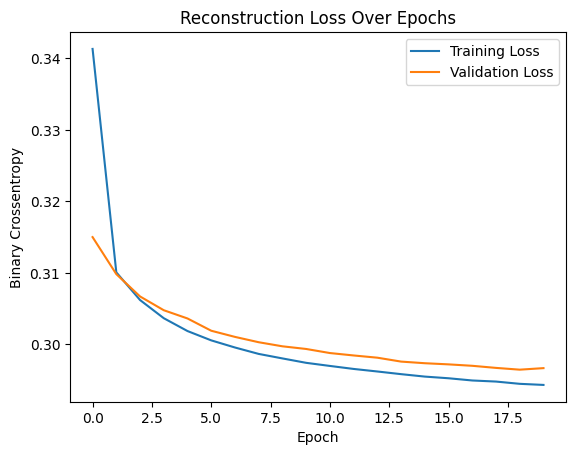

In [12]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Binary Crossentropy")
plt.legend()
plt.title("Reconstruction Loss Over Epochs")
plt.show()

In [13]:
print("Encoded bottleneck shape:", encoded_imgs.shape)

Encoded bottleneck shape: (10000, 7, 7, 16)


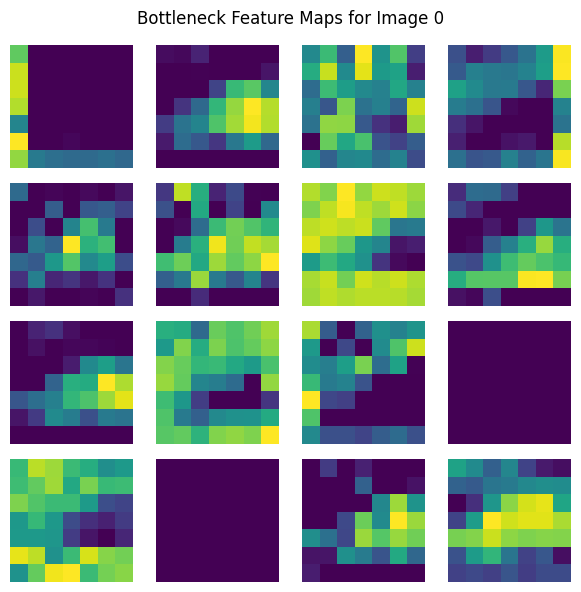

In [16]:
def visualize_bottleneck_channels(encoded, index):
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    fig.suptitle(f"Bottleneck Feature Maps for Image {index}")
    for i, ax in enumerate(axes.flat):
        ax.imshow(encoded[index, :, :, i], cmap='viridis')
        ax.axis("off")
    plt.tight_layout()
    plt.show()

visualize_bottleneck_channels(encoded_imgs, 0)


Analysis:

*    Built a Convolutional Autoencoder that effectively learned to denoise Fashion MNIST images by reconstructing clean outputs from noisy inputs using convolutional and pooling layers.
*   The model utilized a bottleneck layer to compress high-dimensional data into a compact feature space, capturing essential visual patterns.

*   Applied EarlyStopping to prevent overfitting, and visualized both image outputs (original, noisy, denoised) and loss curves to evaluate training progress
*   The model demonstrated strong reconstruction accuracy, validating the approach for image compression and noise removal tasks.



